### 統計學習與深度學習
### Homework 3


請將IPYNB檔上傳至COOL作業區。回答作業時建議使用 "三明治" 答題法。也就是說，先說明要做什麼，然後列出程式碼與結果，最後說明這些結果的意義。作業自己做。嚴禁抄襲。不接受紙本繳交，不接受遲交。請以英文或中文作答。


### 第一題 [分類器、特徵建構、與Stacking]

(50%) 建構分類器時常會透過特徵選擇與Ensemble增強預測能力。本題的目的是讓大家練習這些技巧。本題使用一個中文姓名分類的資料集。這個資料集收集了10730個中文名(不含姓)，以及這些名子對應到的性別。本資料集的資料檔是**namesex_data_v2.csv**，共有三個欄位，gname, sex, fold:
* gname: 不含姓的中文名。
* sex: 1為男性，0為女性。
* fold: 為0 - 9的整數，做為後續切割資料集使用。

我們先將這個資料集讀入Numpy Array，並列印前十筆資料。

In [196]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import numpy as np

f = open('ds/namesex_data_v2.csv', 'r', encoding='utf8')
mydata = csv.DictReader(f)
sexlist = []
namelist = []
foldlist = []
for i, arow in enumerate(mydata):
    if i < 10:
        print(arow)
    sexlist.append(int(arow['sex'].strip()))
    gname = arow['gname'].strip()
    namelist.append(gname)
    foldlist.append(int(arow['fold'].strip()))

sexlist = np.asarray(sexlist)
namelist = np.asarray(namelist)
foldlist = np.asarray(foldlist)
f.close()

OrderedDict([('gname', '承憲'), ('sex', '1'), ('fold', '9')])
OrderedDict([('gname', '均平'), ('sex', '1'), ('fold', '7')])
OrderedDict([('gname', '思安'), ('sex', '0'), ('fold', '6')])
OrderedDict([('gname', '佑誠'), ('sex', '1'), ('fold', '3')])
OrderedDict([('gname', '乃馨'), ('sex', '0'), ('fold', '0')])
OrderedDict([('gname', '婕'), ('sex', '0'), ('fold', '0')])
OrderedDict([('gname', '冠瑜'), ('sex', '0'), ('fold', '1')])
OrderedDict([('gname', '冠學'), ('sex', '1'), ('fold', '0')])
OrderedDict([('gname', '立翰'), ('sex', '1'), ('fold', '2')])
OrderedDict([('gname', '以柔'), ('sex', '0'), ('fold', '6')])


接下來看一些統計數字:

In [2]:
nobs = namelist.shape[0]
print("資料筆數 = ", nobs)

資料筆數 =  10730


In [3]:
avg_sex = np.mean(sexlist)
print("男性比率", avg_sex)

男性比率 0.47940354147250697


這個資料集的男女比率還算是平均，男性佔了47.94%。

我們用了比較迂迴的方式讀檔案，Pandas其實可以直接讀csv檔。接下來做一些基本的資料分析。我們關心幾件事:
* 最常見的名子
* 共有多少個不重複的名子
* 有多少難判斷男女的名子

要回答這些問題，首先對名子加總，計算數量與男性比率，排序之後列出前20個名子:

In [4]:
import pandas as pd
name_df = pd.DataFrame({'sex': sexlist, 'name': namelist, 'fold': foldlist})
sex_tend = name_df[['name', 'sex']].groupby(["name"]).agg(['mean', 'count']).reset_index()
sex_tend.columns = ['-'.join(col).strip() for col in sex_tend.columns.values]
sex_tend = sex_tend.sort_values(['sex-count'], ascending=False)

print("最常見的20個名子:")
sex_tend.head(20)

最常見的20個名子:


,name-,sex-mean,sex-count
3738,承恩,1.000000,20
918,冠廷,1.000000,20
2506,宜蓁,0.000000,18
545,佳穎,0.000000,16
3196,彥廷,0.923077,13
913,冠宇,1.000000,13
3390,思妤,0.000000,13
1019,凱翔,1.000000,13
3769,承翰,1.000000,13
3477,怡萱,0.000000,13


由上面的列表看來，最常見的男性名子是承恩與冠廷，最常見的女性名子是宜蓁與佳穎。而這些常見的名子男性比率都非常接近0或1，表示這些名子沒有性別混淆的問題。

另外一個問題是有多少名子只出現一次:

In [5]:
single_name = np.sum(sex_tend['sex-count'] <= 1)
print("出現一次名子個數: ", single_name, "比率:", single_name / nobs)

出現一次名子個數:  7067 比率: 0.6586206896551724


由結果看來，名子在資料集中只出現一次的比率很高，有65%。也就是說，如果單純的使用訓練資料中出現的名子做為特徵，模型應該會有很差的預測能力。

#### <font color=#800000>為了處理這個問題，我們在接下來的任務中，會使用"Unigram + Full Name"的特徵表示，比如說，"芳瑜"的特徵表示為"芳"、"瑜"，以及原始的名子"芳瑜"。</font>

最後我們來看看性別混淆的名子:

In [6]:
ind1 = (sex_tend['sex-mean'] > 0.4) & (sex_tend['sex-mean'] < 0.6)
sex_amb = sex_tend[ind1]
amb_count = sex_amb['sex-count'].sum()
print("難區分性別姓名數量: ", amb_count, "比率:", amb_count/ nobs)

難區分性別姓名數量:  136 比率: 0.012674743709226468


難以區分性別的名子總數並不高，所占總體資料的比率也很低，只有1.26%，因此不用擔心這個因素會影響預測準確率。

下面來看看幾個容易混淆性別的名子:

In [8]:
sex_amb.head()

,name-,sex-mean,sex-count
6777,育瑋,0.5,4
338,以恩,0.5,4
7783,郁軒,0.5,4
2513,宜謙,0.5,4
5920,祐嘉,0.5,4


#### 實做限制
為了確保可以確實練習到重要技巧，禁用Pycaret (<https://pycaret.org/>) 這類可以自動化調教參數與Ensemble模型的工具。另外也禁止使用`sklearn.ensemble.Stacking.*`。你可以使用sklearn中Pre-processing工具函數與現成的分類器，但參數調教請自行處理。



#### 回答下面問題
#### Q1.1 (10%): 
使用One-hot Encoding建構資料變數。所有資料變數都要是Numpy Array。依照每筆資料其fold值切割為Training (fold <=6)、Validation (fold == 7)、Stacking (fold == 8)、Test (fold == 9)。每個資料集應有特徵Array(二維)以及Label Array(一維)。如前面提到的，每個名子應該要對應到全名以及單字的One-hot Encoding。比如說，"芳瑜"的特徵表示為"芳"、"瑜"，以及原始的名子"芳瑜"。建構特徵表示時應依照個特徵出現的頻率篩選。特徵在訓練資料出現兩次或以上才納入。如果一個特徵被排除，這個特徵出現時應被歸為"\_Other_Feature_"。任何名子只要有出現未被納入的特徵，則其"\_Other_Feature_"的欄位值為1。

舉例而言，假設訓練資料集中有下面三個名子: 承恩、承德、恩賜。在經過特徵頻率篩選之後，只剩下以下特徵: 承、恩。其他特徵，如承恩、承德、恩賜、德、賜皆被排除。因此最後的特徵表示為:

Input | 承 | 恩 | \_Other_Feature_ |
------|----|----|-----------------|
承恩  | 1  | 1   |  1    |
承德  | 1  | 0   |  1  |
恩賜  | 0  | 1   |  1 |

最後應產生以下Numpy Array:
* x_train: Training Features
* y_train: Training Labels
* x_valid: Validation Features
* y_valid: Validation Labels
* x_stack: Stack Features
* y_stack: Stack Labels
* x_test: Test Features
* y_test: Test Labels

請列出每個Numpy Array的Shape以資查驗。

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import numpy as np

f = open('ds/namesex_data_v2.csv', 'r', encoding='utf8')
mydata = csv.DictReader(f)
sexlist = []
namelist = []
foldlist = []
for i, arow in enumerate(mydata):
    sexlist.append(int(arow['sex'].strip()))
    gname = arow['gname'].strip()
    namelist.append(gname)
    foldlist.append(int(arow['fold'].strip()))

sexlist = np.asarray(sexlist)
namelist = np.asarray(namelist)
foldlist = np.asarray(foldlist)
f.close()

In [56]:
import pandas as pd
import collections
from collections import Counter

name_df = pd.DataFrame({'sex': sexlist, 'name': namelist, 'fold': foldlist})
trainset = name_df[name_df['fold'] <= 6]
validset = name_df[name_df['fold'] == 7]
stackset = name_df[name_df['fold'] == 8]
testset = name_df[name_df['fold'] == 9]
#特徵篩選
names =trainset['name']
origin_features = []
train_features = []
for n in names:
    if len(n) >= 2:
        for i in n:
            origin_features.append(i)
    origin_features.append(n)
    cnt = Counter(origin_features)
for c, f in cnt.items():
    if(f >= 2):
        train_features.append(c)
train_features.append('_Other_Feature_')

#整理dataset
#train
fn = len(train_features)
names =trainset['name'].tolist()
n=len(names)
init = np.zeros((n, fn))
x_train = pd.DataFrame(init, columns=train_features,index=names)    
for i in range(n):
    isOtherFeature = True
    for c in names[i]:
        if(c in train_features):
            x_train.at[names[i],c] = 1
    if(n in train_features):
        x_train.at[names[i],n] = 1
        isOtherFeature = False
    if(isOtherFeature == True):
        x_train.at[names[i],'_Other_Feature_'] = 1
y_train= trainset['sex']

#valid       
names =validset['name'].tolist()
n=len(names)
init = np.zeros((n, fn))
x_valid = pd.DataFrame(init, columns=train_features,index=names)    
for i in range(n):
    isOtherFeature = True
    for c in names[i]:
        if(c in train_features):
            x_valid.at[names[i],c] = 1
    if(n in train_features):
        x_valid.at[names[i],n] = 1
        isOtherFeature = False
    if(isOtherFeature == True):
        x_valid.at[names[i],'_Other_Feature_'] = 1
y_valid = validset['sex']

#stack
names =stackset['name'].tolist()
n=len(names)
init = np.zeros((n, fn))
x_stack = pd.DataFrame(init, columns=train_features,index=names)    
for i in range(n):
    isOtherFeature = True
    for c in names[i]:
        if(c in train_features):
            x_stack.at[names[i],c] = 1
    if(n in train_features):
        x_stack.at[names[i],n] = 1
        isOtherFeature = False
    if(isOtherFeature == True):
        x_stack.at[names[i],'_Other_Feature_'] = 1
y_stack = stackset['sex']

#test        
names =testset['name'].tolist()
n=len(names)
init = np.zeros((n, fn))
x_test = pd.DataFrame(init, columns=train_features,index=names)    
for i in range(n):
    isOtherFeature = True
    for c in names[i]:
        if(c in train_features):
            x_test.at[names[i],c] = 1
    if(n in train_features):
        x_test.at[names[i],n] = 1
        isOtherFeature = False
    if(isOtherFeature == True):
        x_test.at[names[i],'_Other_Feature_'] = 1
y_test = testset['sex']
        
print("shape of x_train:", x_train.shape)
print("shape of y_train:", y_train.shape)
print("shape of x_valid:", x_valid.shape)
print("shape of y_valid:", y_valid.shape)
print("shape of x_stack:", x_stack.shape)
print("shape of y_stack:", y_stack.shape)
print("shape of x_test:", x_test.shape)
print("shape of y_test:", y_test.shape)

shape of x_train: (7483, 1630)
shape of y_train: (7483,)
shape of x_valid: (1110, 1630)
shape of y_valid: (1110,)
shape of x_stack: (1073, 1630)
shape of y_stack: (1073,)
shape of x_test: (1064, 1630)
shape of y_test: (1064,)


#### Q1.2 (10%):
使用`sklearn.linear_model.LogisticRegression()`建構Logistic Regression分類模型。利用Training與Validation調教Regularization Coefficient $c$。Grid Search的小值為$10^{-4}$，最大值是$1,000$，總共取20個點，使用等比級數間隔。取F-1 Score最大之Regularization Coefficient，印出此數值(以下稱bestc)。將Training與Validation合併後，令Regularizaiton Coefficient為bestc，訓練最終模型，並報告Test Data的Accuracy, Precision, Recall, 與F-1 Score。另外列出係數絕對值最大的20個特徵。注意應列出未取絕對值的係數數值，方知特徵的性別傾向。討論Prediction Performance與重要特徵的合理性。


In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
c_List = np.logspace(start=-4, stop=3, num=20, endpoint=True, base=10.0, dtype=None)
bestF1 = 0
bestC = 0

for c in c_List:
    clf = LogisticRegression(C = c).fit(x_train, y_train)
    y_valid_pred = clf.predict(x_valid)
    f1 = f1_score(y_valid, y_valid_pred, average='macro')
    if(f1 > bestF1):
        bestF1 = f1
        bestC = c


取F-1 Score最大之Regularization Coefficient，印出此數值(以下稱bestc)

In [74]:
print("bestc:",bestC,", 最大F-1 Score=",bestF1)

bestc: 14.38449888287663 , 最大F-1 Score= 0.9043103448275861


In [88]:
from sklearn.metrics import precision_recall_fscore_support
new_x_train = pd.concat([x_train, x_valid])
new_y_train = pd.concat([y_train, y_valid])
lr= LogisticRegression(C = bestC).fit(new_x_train, new_y_train)
y_pred = lr.predict(x_test)
accuracy = lr.score(x_test,y_test)
evaluation = precision_recall_fscore_support(y_test, y_pred, average='macro')


報告Test Data的Accuracy, Precision, Recall, 與F-1 Score

In [86]:
print("bestc=", bestC)
print("accuracy=", accuracy)
print("precision=", evaluation[0])
print("recall=", evaluation[1])
print("f1=", evaluation[2])

bestc= 14.38449888287663
accuracy= 0.8853383458646616
precision= 0.8843180748806883
recall= 0.8865939024694038
f1= 0.8849219858156028


F1score有達到0.88以上，accuracy也蠻高，這是一個表現不錯的model

In [130]:
arrange = np.abs(lr.coef_).argsort().reshape(-1)
Top20=arrange[:-21:-1]
print('列出係數絕對值最大的20個特徵=>')
for i in Top20:
    print(train_features[i], lr.coef_[0][i])

列出係數絕對值最大的20個特徵=>
妤 -6.620134427011389
傑 6.15053036568656
婷 -6.134383889620254
雯 -5.924781029434965
潔 -5.817227571428794
美 -5.779119061696084
蓉 -5.695239747878068
琳 -5.580703952995882
婕 -5.5135244332780875
姿 -5.489276827121469
靜 -5.481458604257658
柔 -5.441244158254573
凌 -5.396141710065862
綺 -5.325762540251016
薇 -5.273207262599624
綾 -5.272743029417817
森 5.254387742377345
雅 -5.2293308090760675
萱 -5.222593265141941
妍 -5.137805629093386


係數正負的關係在於，係數負的名字的字，會讓名字偏向猜為女生的，係數正的名字的字，會讓名字偏向猜為男生的。
仔細觀察上面20個特徵，上面的字確實如果放在名字裡，直觀上可以準確猜出名字主人的性別。

#### Q1.3 (10%):
使用`sklearn.ensemble.RandomForestClassifier()`建構Random Forest分類模型。利用Training與Validation調教Number of Tress (i.e., n_estimators)。Grid Search的小值為$5$，最大值是$1,000$，總共取10個點，使用等比級數間隔。取F-1 Score最大之n_estimators，印出此數值(best_nest)。將Training與Validation合併後，令n_estimators為best_nest，訓練最終模型，並報告Test Data的Accuracy, Precision, Recall, 與F-1 Score。另外列出最重要的20個特徵。討論Prediction Performance與重要特徵的合理性。

In [152]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

n_List = np.logspace(start=np.log10(5), stop=3, num=10 ,base=10.0).astype(int)

best_F1 = 0
best_nest = 0

for n in n_List:
    clf = RandomForestClassifier(n_estimators = n).fit(x_train, y_train)
    y_valid_pred = clf.predict(x_valid)
    f1 = f1_score(y_valid, y_valid_pred, average='macro')
    if(f1 > best_F1):
        best_F1 = f1
        best_nest = n
        

N: 5 , f1= 0.8672649519113049
N: 9 , f1= 0.8663955757970072
N: 16 , f1= 0.8806844277380204
N: 29 , f1= 0.8762945470193795
N: 52 , f1= 0.8824152542372881
N: 94 , f1= 0.8798406991915313
N: 170 , f1= 0.8779598900539549
N: 308 , f1= 0.8842755493001799
N: 555 , f1= 0.8752865852069927
N: 1000 , f1= 0.8825163483833989
BestN:  308


取F-1 Score最大之n_estimators，印出此數值(best_nest)

In [156]:
print("Best_nest: ", best_nest, "最大F-1 Score=",best_F1)

Best_nest:  308 最大F-1 Score= 0.8842755493001799


In [164]:
from sklearn.metrics import precision_recall_fscore_support

new_x_train = pd.concat([x_train, x_valid])
new_y_train = pd.concat([y_train, y_valid])

rf = RandomForestClassifier(n_estimators = best_nest).fit(new_x_train, new_y_train)
y_pred =rf.predict(x_test)
accuracy = rf.score(x_test,y_test)
evaluation = precision_recall_fscore_support(y_test, y_pred, average='macro')



報告Test Data的Accuracy, Precision, Recall, 與F-1 Score

In [170]:
print("Best_nest=", best_nest)
print("Accuracy=:", accuracy)
print("Precision=:",evaluation[0])
print("Recall=:", evaluation[1])
print("F-1 Score=", evaluation[2])

Best_nest= 308
Accuracy=: 0.849624060150376
Precision=: 0.8483423915933674
Recall=: 0.8496613866953264
F-1 Score= 0.8488529014844806


F1score有到0.84以上，然而比起LogisticRegression似乎遜色許多

最重要的20個特徵

In [348]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
for i in range(20):
    print(f"{train_features[i]}:{importances[indices[i]]}")

思:0.020835704409219055
安:0.014974695849793995
佑:0.014872733368374016
誠:0.013780060120969379
乃:0.013319504969807827
馨:0.00970164357045498
婕:0.009685623489023824
冠:0.009301958483086296
瑜:0.009287907825922995
學:0.008890418564453668
立:0.008889910308784459
翰:0.008806273302449315
以:0.008687587675105515
柔:0.008615089008272054
士:0.008588151243015348
耘:0.008490776548710903
佾:0.008480193498206624
蓁:0.00823420609967073
姿:0.008051081959203617
嘉:0.007804372322013652


確實這20個特徵有許多是很有效辨別是男生是女生的特徵，然而其中卻也參雜幾個沒有那麼直觀的特徵，像是思、以等，這些字在現代我們比較偏向將它們放於中性的位置

#### Q1.4 (10%):
使用`sklearn.ensemble.GradientBoostingClassifier()`建構Gradient Boosting Decision Tree (GBDT)分類模型。利用Training與Validation調教learning_rate與n_estimators。考慮以下Learning Rate: 0.1, 0.5, 1。每一個Learning Rate設n_estimator為1,500並估計一個GBDT分類器，計算1,500個Stages下Validation F-1 Score值，繪圖，並找出讓F-1 Score最大的Stage與F-1 Score最大值。對所有Learning Rate重複同樣程序，找出最佳的Learning Rate (稱best_lr) 與其對應的Number of Stages(best_nstg)。將Training與Validation合併後，令learning_rate為best_lr, n_estimators為best_nstg，訓練最終模型，並報告Test Data的Accuracy, Precision, Recall, 與F-1 Score。另外列出最重要的20個特徵。討論Prediction Performance與重要特徵的合理性。

In [184]:
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib as plt

lr_list = [0.1, 0.5, 1]
best_F1 = 0
best_Lrate = 0
best_Stage = 0
f1_list = []

for l in lr_list:    
    gb = GradientBoostingClassifier(n_estimators = 1500, learning_rate = l).fit(x_train, y_train)
    
    for index, y_valid_pred in enumerate(gb.staged_predict(x_valid)):
        f1 = f1_score(y_valid, y_valid_pred, average='macro')
        f1_list.append(f1)
        if(f1 > best_F1):
            best_Stage = index
            best_F1 = f1
            best_lr = l      


計算1,500個Stages下Validation F-1 Score值，繪圖，

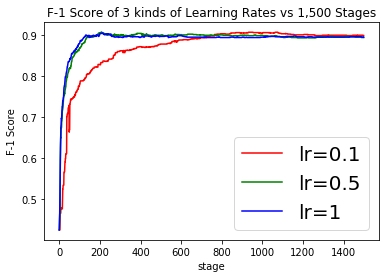

In [190]:
import matplotlib.pyplot as plt

f1_01=f1_list[:1500]
f1_05=f1_list[1500:3000]
f1_1=f1_list[3000:]

plt.plot(f1_01, color = 'r', label="lr=0.1")
plt.plot(f1_05, color = 'g', label="lr=0.5")
plt.plot(f1_1, color = 'b', label="lr=1")
plt.title('3種Learning Rate，1,500個Stages下Validation F-1 Score值')
plt.title('F-1 Score of 3 kinds of Learning Rates vs 1,500 Stages')
plt.xlabel('stage')
plt.ylabel('F-1 Score')
plt.legend(loc = "best", fontsize=20)
plt.show()



In [191]:
len(f1_list)

4500

找出讓F-1 Score最大的Stage與F-1 Score最大值

In [192]:
print("Best_LR=", best_lr)
print("BestF-1 Score=", best_F1)
print("Best number of stage=", best_Stage)

Best_LR= 0.1
BestF-1 Score= 0.9062283725781349
Best number of stage= 932


In [193]:
from sklearn.metrics import precision_recall_fscore_support

new_x_train = pd.concat([x_train, x_valid])
new_y_train = pd.concat([y_train, y_valid])
gb = GradientBoostingClassifier(n_estimators = best_Stage, learning_rate = best_lr).fit(new_x_train, new_y_train)
y_test_pred = gb.predict(x_test)
accuracy = gb.score(x_test,y_test)
evaluation = precision_recall_fscore_support(y_test, y_test_pred, average='macro')


報告Test Data的Accuracy, Precision, Recall, 與F-1 Score

In [194]:
print("Best_LR=", best_lr)
print("Best number of stage=", best_Stage)
print("Accuracy=", accuracy)
print("Precision=", evaluation[0])
print("Recall=", evaluation[1])
print("F-1 Score=", evaluation[2])

Best_LR= 0.1
Best number of stage= 932
Accuracy= 0.8656015037593985
Precision= 0.8661250653737969
Recall= 0.8687166146498742
F-1 Score= 0.865420693010194


F1score有到0.86以上，然而比起LogisticRegression似乎遜色許多

In [346]:
importances = gb.feature_importances_
indices = np.argsort(importances)[::-1]
for i in range(20):
    print(f"{train_features[i]}:{importances[indices[i]]}")

思:0.031217378232330197
安:0.02343763885152156
佑:0.02077877342426366
誠:0.02013834400646577
乃:0.019459946931765264
馨:0.013109195180311345
婕:0.013050699033301654
冠:0.013026809979434242
瑜:0.012957132390764988
學:0.012274536955763192
立:0.011989490293291594
翰:0.011899319972928446
以:0.011795919467288153
柔:0.011509660130334845
士:0.011256791200323068
耘:0.011196270798230847
佾:0.010971969891305649
蓁:0.010779937517748278
姿:0.010272329323035718
嘉:0.010191962435459941


確實這20個特徵有許多是很有效辨別是男生是女生的特徵，然而其中卻也存在著不那麼直觀判斷是否為男生女生的特徵

#### Q1.5 (10%):
取用前面所建構的Logistic Regression, Random Forest, 與Gradient Boosting Decision Tree, 組合(Stacking)成一個新的分類器。我們使用Logistic Regression without Penalty建構這個Stacking分類器。訓練資料為Stacking資料集。各分類器輸入的特徵為男生預測機率(注意: 不是分類結果)。列出Stacking分類器的係數，討論係數的意義，並計算這個Stacking分類器在Test資料集的預測能力。

In [218]:
l_stack = lr.predict_proba(x_stack)[:,1]
r_stack = rf.predict_proba(x_stack)[:,1]
g_stack = gb.predict_proba(x_stack)[:,1]
new_stack = []
for i in range(len(l_stack)):
    new_stack.append([l_stack[i], r_stack[i], g_stack[i]])
new_stack=np.array(new_stack)

l_test = lr.predict_proba(x_test)[:,1]
r_test = rf.predict_proba(x_test)[:,1]
g_test = gb.predict_proba(x_test)[:,1]
stack_test = []
for i in range(len(l_test)):
    stack_test.append([l_test[i], r_test[i], g_test[i]])
stack_test=np.array(stack_test)


s = LogisticRegression(penalty="none").fit(new_stack, y_stack)
y_pred = s.predict(stack_test)
accuracy = s.score(stack_test,y_test)
evaluation = precision_recall_fscore_support(y_test, y_pred, average='macro')

列出Stacking分類器的係數

In [220]:
classer=['Logistic Regression','Random Forest','Gradient Boosting Decision Tree']
for i in range(len(classer)):
    print(classer[i], s.coef_[0][i])

Logistic Regression 3.8761895346384456
Random Forest -0.3419983366030553
Gradient Boosting Decision Tree 4.437327907505609


計算這個Stacking分類器在Test資料集的預測能力

In [222]:

print("Accuracy=", accuracy)
print("Precision=", evaluation[0])
print("Recall=", evaluation[1])
print("F-1 Score=", evaluation[2])

Accuracy= 0.8862781954887218
Precision= 0.8851879379910809
Recall= 0.8873003106772622
F-1 Score= 0.8858254693346175


F1score有達到0.88以上，accuracy也蠻高，這是一個表現不錯的model

------
### Solution
------
請自行增加Cell並回答問題。

## 第二題 [Data Visualization via Dimensionality Reduction]

Data visualization is a useful technique that can help us understand the characteristics of a dataset. We are going to practice this skill using the  University Offer of Admission Dataset (UDOAD).  

#### Dataset: University Department Offer of Admission Dataset (UDOAD; 大學推薦甄選資料集)

Many high school students get admitted to universities through an application and screening process that requires each university department to offer admission to applicants first before students can choose where they want to go. Suppose we think of applicants as the customers of an academic department. In that case, the duplications of offered applicants from different departments can be used to understand the competitive relationships between academic departments. We are going to visualize this competition relationship using UDOAD. 

UDOAD was collected through a popular online offer searching service (https://freshman.tw/; site no longer operational) for the 2017 academic year. We collected the offers received by each applicant as well as the basic information for academic departments. This dataset contains two files
* student_admission106.csv: the offers received by each student applicant. 
* univ_name106short1.csv: the basic information, such as the name and field of academic departments. 

Below is the first few records of these two files:

In [223]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

stu_adm = pd.read_csv('ds/student_admission106.csv', encoding="utf-8", dtype=str)
uname = pd.read_csv('ds/univ_name106short1.csv', encoding="utf-8", dtype=str)

all_depid = stu_adm['department_id'].unique()
all_stuid = stu_adm['student_id'].unique()

ndepid = all_depid.shape[0]
nstuid = all_stuid.shape[0]
print("There are %d students and %d departments in total." % (nstuid, ndepid))

print("offers received by students:")
stu_adm.head(10)

There are 60461 students and 1976 departments in total.
offers received by students:


,school_id,department_id,student_id,student_name,state,location1,location2
0,001,001012,10246842,黃士玹,正1,南部,台南考區
1,001,001012,10042237,黃冠婷,正2,北部,台北考區
2,001,001012,10008031,鍾大方,正3,北部,台北考區
3,001,001012,10201525,曾信豪,正4,中部,彰化考區
4,001,001012,10014615,陳品儒,正5,北部,台北考區
5,001,001012,10294018,侯思筠,正6,東部,宜蘭考區
6,001,001012,10022810,吳悅慈,正7,北部,台北考區
7,001,001012,10236223,陳俞潔,正8,南部,台南考區
8,001,001012,10025909,蕭宇廷,正9,北部,台北考區
9,001,001012,10123708,吳岱軒,正10,北部,中壢考區


The department_id can uniquely identify an academic department. We do not care about the ranking of admission here, and you should ignore the "state" column. We only care about the "co-application" relations in this dataset. You should use student_id to identify a student applicant uniquely. 

In [224]:
print("academic department basic information:")
uname.head(10)

academic department basic information:


,year,school_id,department_id,school_name,department_name,category_id,category_name,school_name_abbr,department_name_abbr
0,106,006,006042,國立政治大學,教育學系,1,教育,政大,教育
1,106,006,006052,國立政治大學,教育學系(公費生),1,教育,政大,教育(公)
2,106,006,006062,國立政治大學,教育學系(原住民公費生),1,教育,政大,教育(原住民)
3,106,006,006022,國立政治大學,歷史學系,2,藝術及人文,政大,歷史
4,106,006,006152,國立政治大學,民族學系,2,藝術及人文,政大,民族學
5,106,006,006032,國立政治大學,哲學系,2,藝術及人文,政大,哲學
6,106,006,006262,國立政治大學,英國語文學系,2,藝術及人文,政大,英國語文
7,106,006,006292,國立政治大學,日本語文學系,2,藝術及人文,政大,日本語文
8,106,006,006272,國立政治大學,阿拉伯語文學系,2,藝術及人文,政大,阿拉伯語文
9,106,006,006302,國立政治大學,韓國語文學系,2,藝術及人文,政大,韓國語文


You can use this dataset to identify the name of a department_id. The school_name and department_name contain the "full name" of an academic department. To facilitate visualization, we also provide "shorter names" in school_name_abbr and department_name_abbr. The category_name is the field of an academic department. This field is essential in our visualization exercise since you should color each data point according to its category_name. 

#### Implementation Restrictions
You are allowed to use any Python libraries in your solution. 

### Data Preparation
Our focus is on the relationships between departments. To do this, we need to convert the raw data into a "matrix" representation. Each row represents an academic department, and each column represents a student applicant. The cell's value is one if a student applied for admission to the corresponding academic department, and 0 otherwise. 

To avoid potential numerical problems, we only include an academic department if it received ten or more applications. Moreover, we only include a student applicant if he or she applied for more than one academic department. 

Note that the two conditions should be satisfied "as is" in after preprocessing. For example, suppose a student applied for two departments in the original dataset, and one of the departments was removed. In that case, this student should be removed because the student only applied for one department in the processed dataset. 



In [225]:
%matplotlib inline
import numpy as np
import pandas as pd

stu_adm = pd.read_csv('ds/student_admission106.csv', encoding="utf-8", dtype=str)
uname = pd.read_csv('ds/univ_name106short1.csv', encoding="utf-8", dtype=str)

all_depid = stu_adm['department_id'].unique()
all_stuid = stu_adm['student_id'].unique()

ndepid = all_depid.shape[0]
nstuid = all_stuid.shape[0]
print("In raw data, there are %d students and %d departments in total." % (nstuid, ndepid))

#construct the department-student matrix (i.e. array). 
dep_stu = np.zeros((ndepid, nstuid))
rowname = all_depid.copy()

depid_seq_map = dict()
for i in range(ndepid):
    depid_seq_map[all_depid[i]] = i

stuid_seq_map = dict()
for i in range(nstuid):
    stuid_seq_map[all_stuid[i]] = i

for cindex, row in stu_adm.iterrows():
    #print(cindex, row)
    dep_seq = depid_seq_map[row['department_id']]
    stu_seq = stuid_seq_map[row['student_id']]
    #print(dep_seq, stu_seq)
    dep_stu[dep_seq, stu_seq] = 1

#Remove very small departments.
min_stu_per_dep = 10
min_apply_dep_per_stu = 2

#remove small departments and single-application students. 
dep_apply_sum = np.sum(dep_stu, axis = 1)
keeprow = dep_apply_sum >= min_stu_per_dep
rowname = rowname[keeprow]
dep_stu2 = dep_stu[keeprow,:]
stu_apply_sum = np.sum(dep_stu2, axis = 0)
dep_stu2 = dep_stu2[:, stu_apply_sum >= min_apply_dep_per_stu]

#another run of filtering
dep_apply_sum = np.sum(dep_stu2, axis = 1)
dep_stu2 = dep_stu2[dep_apply_sum >= min_stu_per_dep,:]
rowname = rowname[dep_apply_sum >= min_stu_per_dep]
stu_apply_sum = np.sum(dep_stu2, axis = 0)
dep_stu2 = dep_stu2[:, stu_apply_sum >= min_apply_dep_per_stu]

#third run of filtering
dep_apply_sum = np.sum(dep_stu2, axis = 1)
dep_stu2 = dep_stu2[dep_apply_sum >= min_stu_per_dep,:]
rowname = rowname[dep_apply_sum >= min_stu_per_dep]

stu_apply_sum = np.sum(dep_stu2, axis = 0)
dep_stu2 = dep_stu2[:, stu_apply_sum >= min_apply_dep_per_stu]

#check to make sure the two conditions are satisfied. 
dep_apply_sum = np.sum(dep_stu2, axis = 1)
print("Number of department too small:", np.sum(dep_apply_sum < min_stu_per_dep))
stu_apply_sum = np.sum(dep_stu2, axis = 0)
print("Number of students applying only one department:", np.sum(stu_apply_sum <min_apply_dep_per_stu))

#now both conditions are satisfied.

In raw data, there are 60461 students and 1976 departments in total.
Number of department too small: 0
Number of students applying only one department: 0


Report the number of academic departments and student applicants in the processed dataset: 

In [226]:
num_dep, num_stu = dep_stu2.shape
print("In final dataset, there are", num_dep, "academic departments and", num_stu, "student applicants.")

In final dataset, there are 1917 academic departments and 47386 student applicants.


Report the top ten departments that received the most applications and the number of applications they received:

In [227]:
uname['depname'] = uname.school_name_abbr + uname.department_name_abbr
uname2 = uname[['department_id', 'depname', 'category_name']].copy()
#this is for later use, to color data points. 
category_id, category_levels = pd.factorize(uname2.category_name)
#uname2['category_id'] = category_id / np.max(category_id)
uname2['category_id'] = category_id

#create a data frame for column name
colname_df = pd.DataFrame({'department_id': rowname})
colname_df = colname_df.merge(uname2, how = "left", on="department_id")

In [228]:
topdepid = np.argsort(dep_apply_sum)[::-1]
topn = 10
topdep = pd.DataFrame({'department_id': rowname[topdepid[0:topn]], 
                       'department_name': colname_df.depname.values[topdepid[0:topn]],
                       'num_applicant': dep_apply_sum[topdepid[0:topn]]
                       }) 
topdep

,department_id,department_name,num_applicant
0,008122,中原機械工程學,386.0
1,012052,中醫藥學,376.0
2,046032,銘傳會計（臺北）,367.0
3,004382,成大電機,357.0
4,005192,東吳企業管理,353.0
5,008112,中原土木,353.0
6,005182,東吳會計,351.0
7,015342,逢甲財金,340.0
8,045012,義守電機,339.0
9,046162,銘傳應用英語（桃園）,329.0


### Answer the following questions
Visualize academic departments in the following questions. In all plots, you should color data points according to the academic department's category. Moreover, you should provide a legend or a picture that illustrates the mapping between colors and category names. Visualize the data using two-dimensional plots. Note that it is your responsibility to study the documentation of your choice libraries and make sure that the results are reasonable. 
* Q2.1 (10%): Visualize academic departments using the first eight principal components. Use your judgment to select multiple pairs of principal components to visualize. Discuss the visual patterns concerning department categories. 
* Q2.2 (10%): Visualize academic departments using multiple dimensional scaling. Consider both the metric and non-metric settings. Discuss the result. 
* Q2.3 (10%): Visualize academic departments using Locally Linear Embedding. Consider three variations: (1) Use 20 neighbors to construct the weight matrix; (2) Use 40 neighbors to construct the weight matrix; (3) Perform PCA transformation first, and use the first 100 principal components as the input to LLE (with 20 neighbors). Discuss the result. 
* Q2.4 (10%): Visualize academic departments using Kernel PCA. You should at least consider the RBF and Cosine kernel. It is your responsibility to select reasonably good kernel parameters. Discuss the result. 
* Q2.5 (10%): Visualize academic departments using t-SNE. You should consider at least the Euclidian, Cosine, and Jaccard metric. Set numpy random seed so that your results can be repeated. Discuss the result. 
* Q2.6 (10%) Select the most promising visualization method in the previous question and refine the result. You should color points by department category. Label each data point with its name so that we can quickly identify a data point on the picture. Moreover, you should try to reduce the problem caused by overlapping points and labels. Output an image that is large enough so that a user can easily identify a department and its neighbors. Jupyter Lab has limitations on the largest picture size. To overcome this problem, output the picture to a separate file and submit the file for grading. Your score depends on how useful, readable, and visually pleasing of your visualization results. 

Q2.1 (10%): Visualize academic departments using the first eight principal components. Use your judgment to select multiple pairs of principal components to visualize. Discuss the visual patterns concerning department categories.

取得所有的 categories 種類，以及對應的顏色 

In [331]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


color_dict = {}
colname_df = pd.DataFrame({'department_id': rowname})

colname_df = colname_df.merge(uname2, how = "left", on="department_id")
cid = colname_df['category_id'].unique()
for k, v in zip(cid, ['lightpink', 'red', 'orange', 'yellow', 'springgreen', 'green', 'royalblue', 'navy', 'violet', 'purple', 'gray']):
    color_dict[k] = v


cid_all = []
for idx in colname_df['category_id']:
    cid_all.append(idx)
cid_all = np.array(cid_all)

color_map = []
for c in cid_all:
    c=int(c)
    color_map.append(color_dict[c])


做 8 components 的 pca

In [320]:
pca = PCA(n_components=8)
pc8 = pca.fit_transform(dep_stu2)

visualize
分別用 (p1, p2), (p3, p4), (p5, p6), (p7, p8) 視覺化

 (p1, p2)


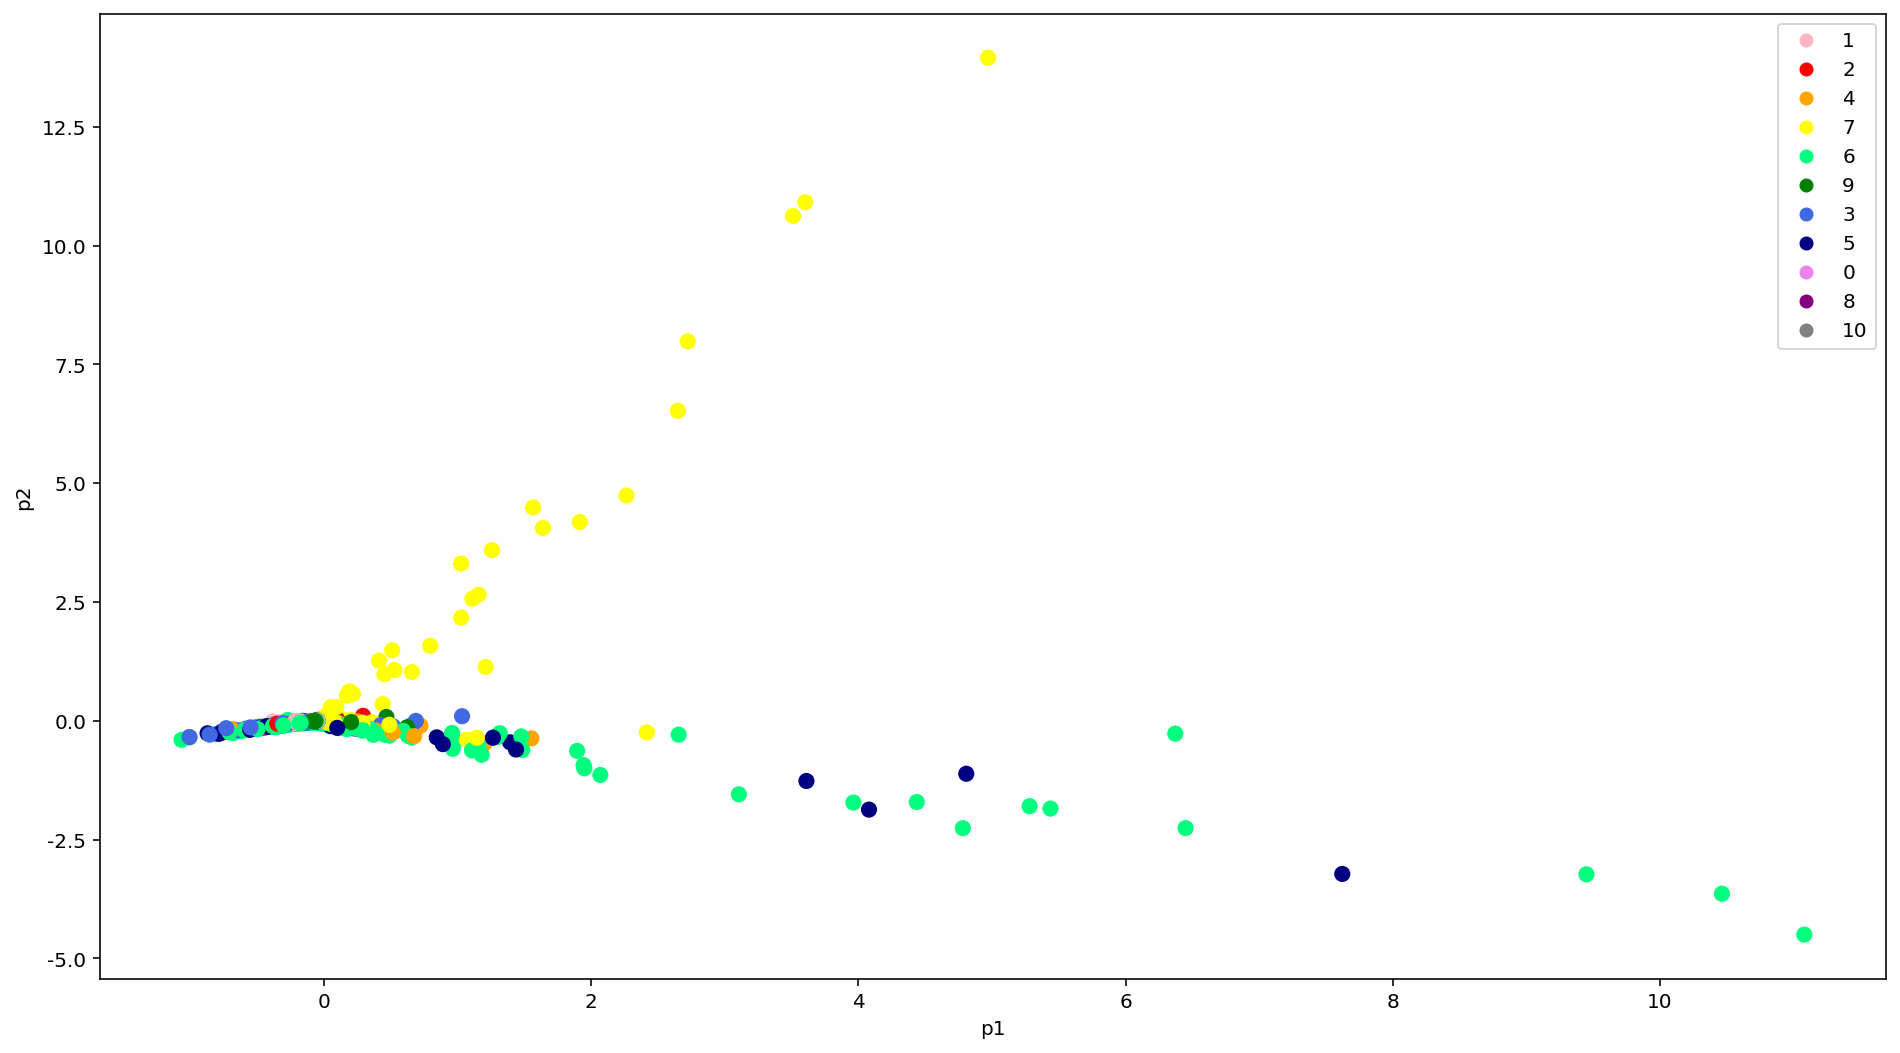

In [340]:
print(" (p1, p2)")
plt.xlabel(f'p{1}')
plt.ylabel(f'p{2}')    
plt.scatter(pc8[:,0], pc8[:,0+1], s=50, c=color_map)
markers = [plt.Line2D([0,0], [0,0], color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.legend(markers, color_dict.keys(), numpoints=1)
plt.show()


 (p3, p4)


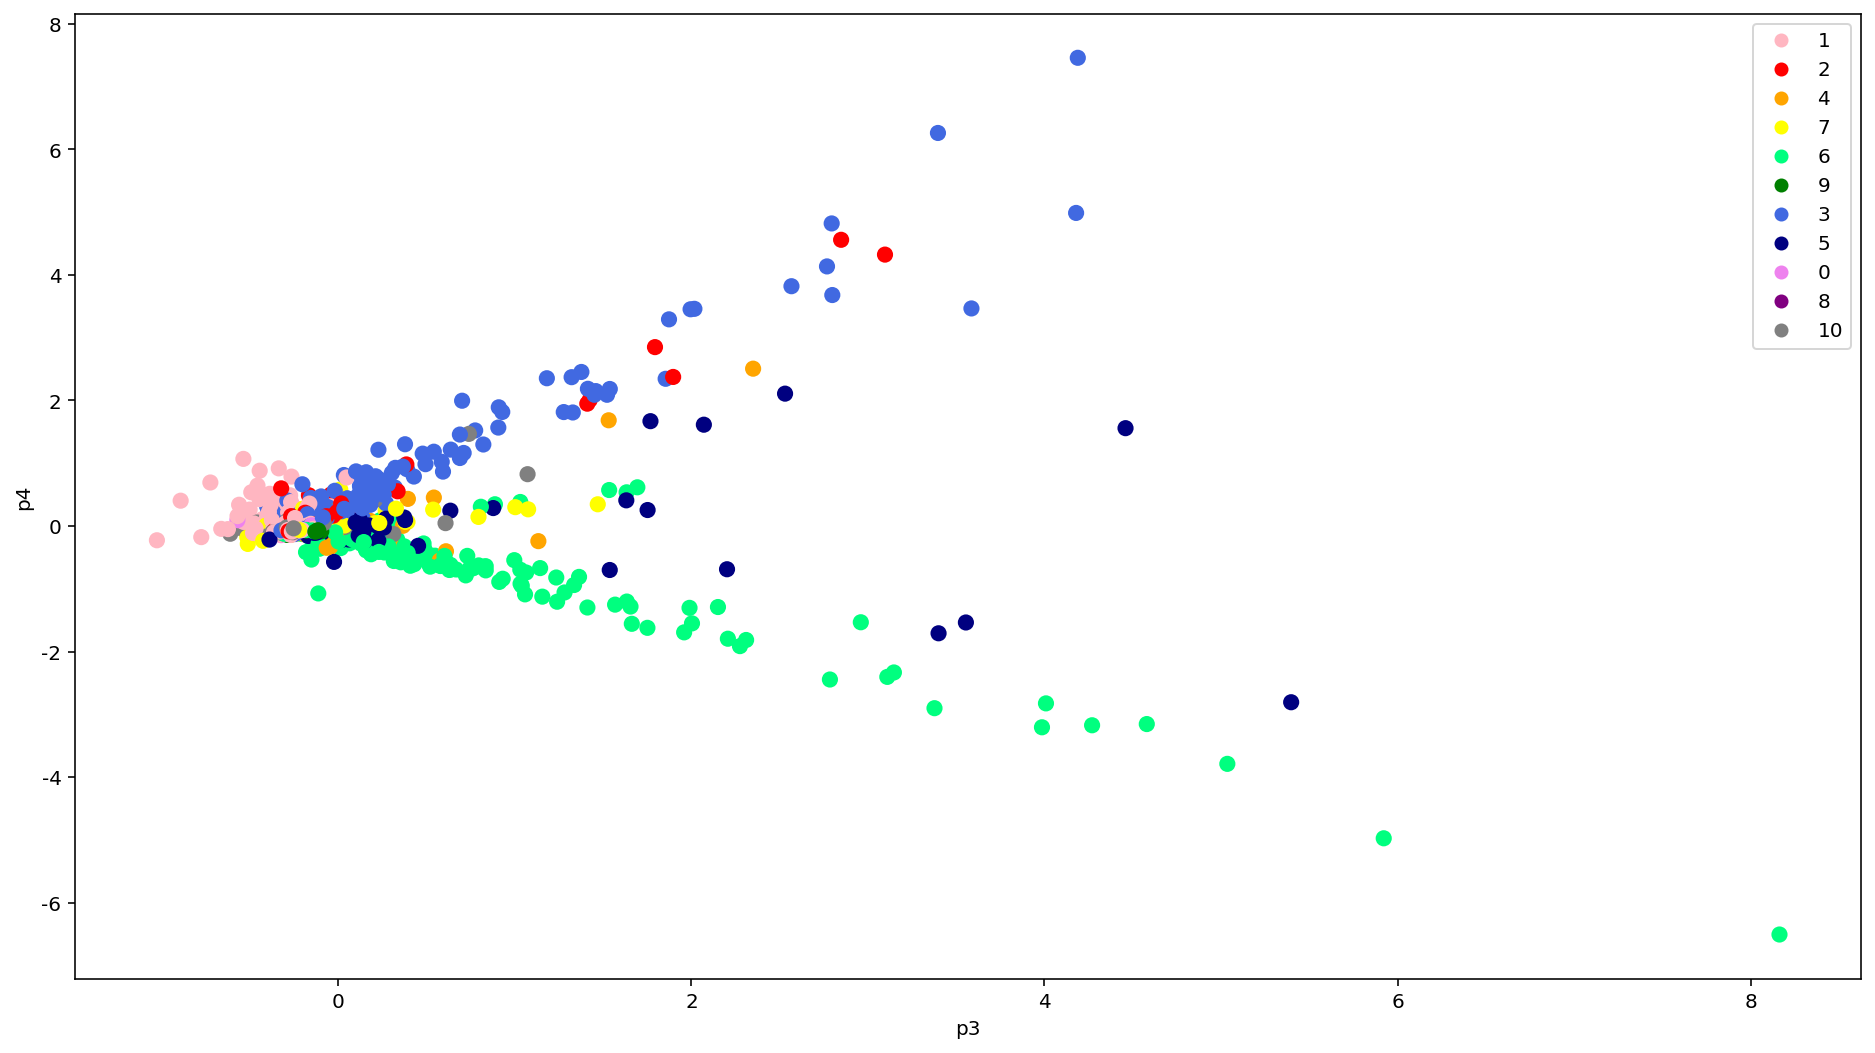

In [341]:
print(" (p3, p4)")
plt.xlabel(f'p{3}')
plt.ylabel(f'p{4}')    
plt.scatter(pc8[:,2], pc8[:,2+1], s=50, c=color_map)
markers = [plt.Line2D([0,0], [0,0], color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.legend(markers, color_dict.keys(), numpoints=1)
plt.show()

 (p5, p6)


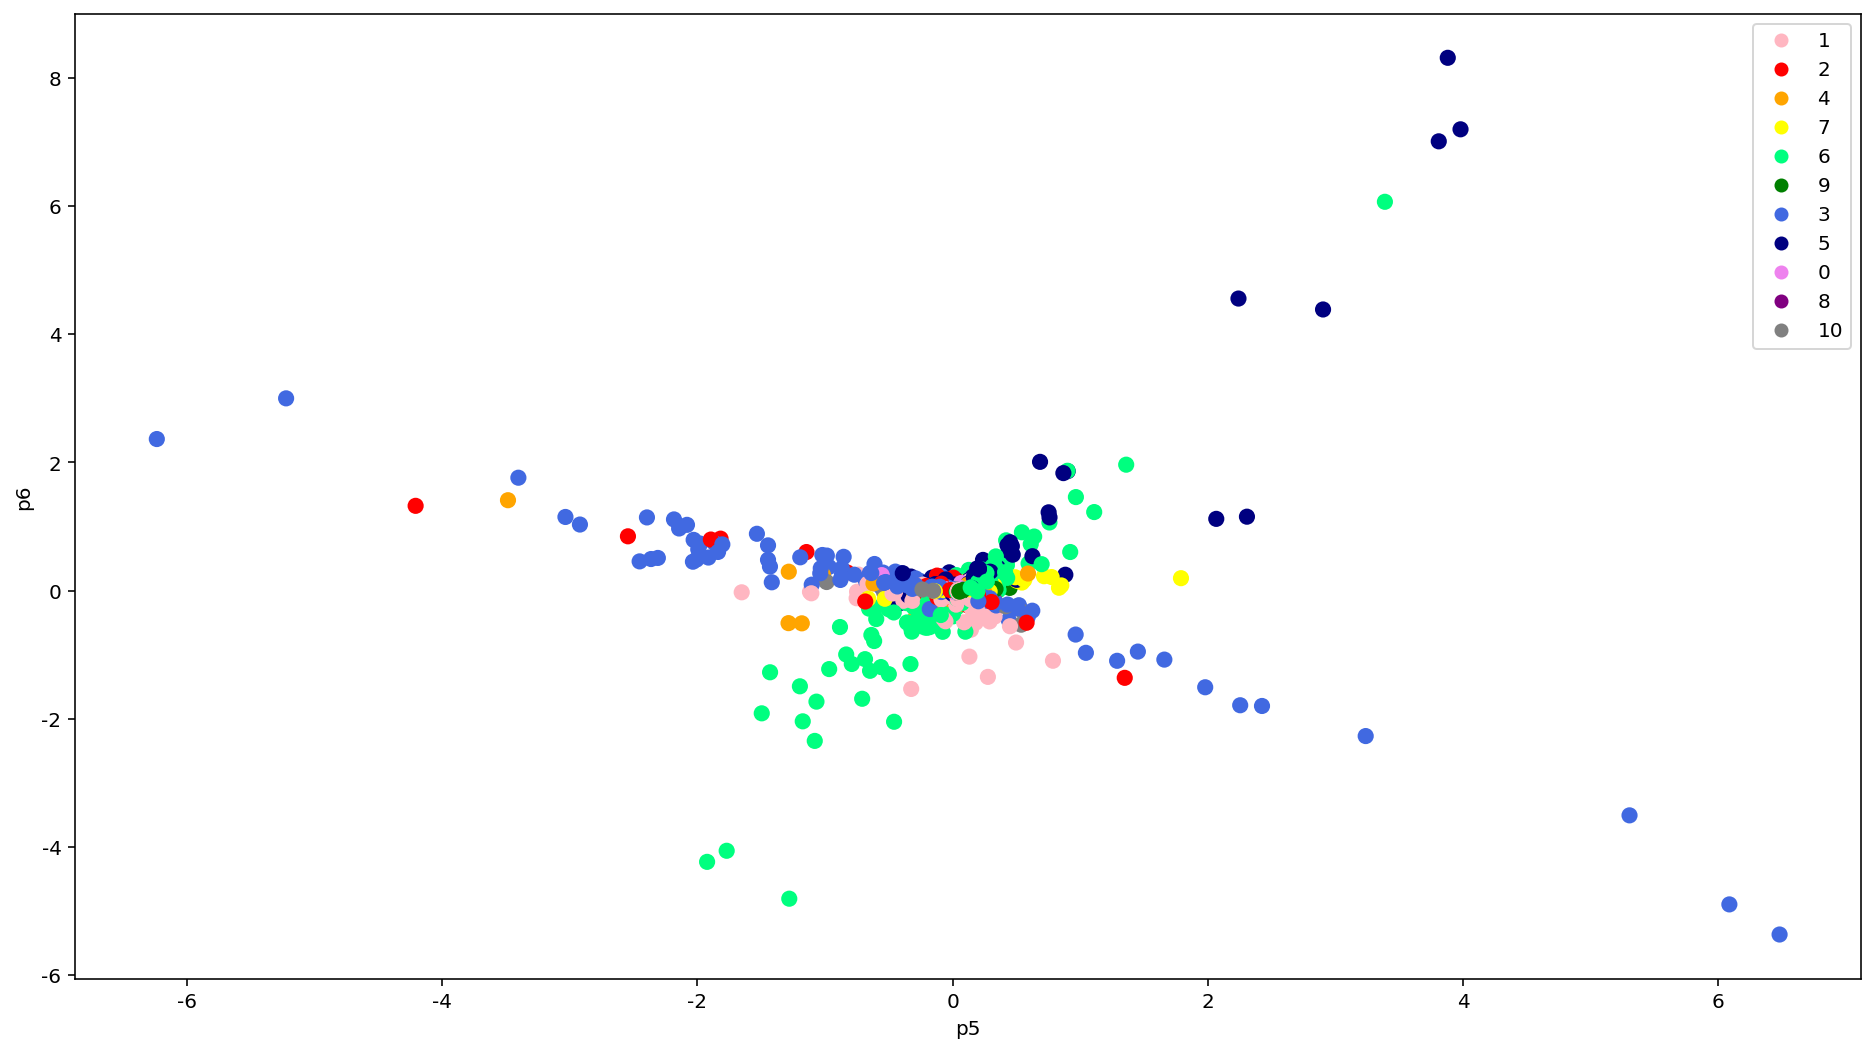

In [342]:
print(" (p5, p6)")
plt.xlabel(f'p{5}')
plt.ylabel(f'p{6}')    
plt.scatter(pc8[:,4], pc8[:,4+1], s=50, c=color_map)
markers = [plt.Line2D([0,0], [0,0], color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.legend(markers, color_dict.keys(), numpoints=1)
plt.show()

 (p7, p8)


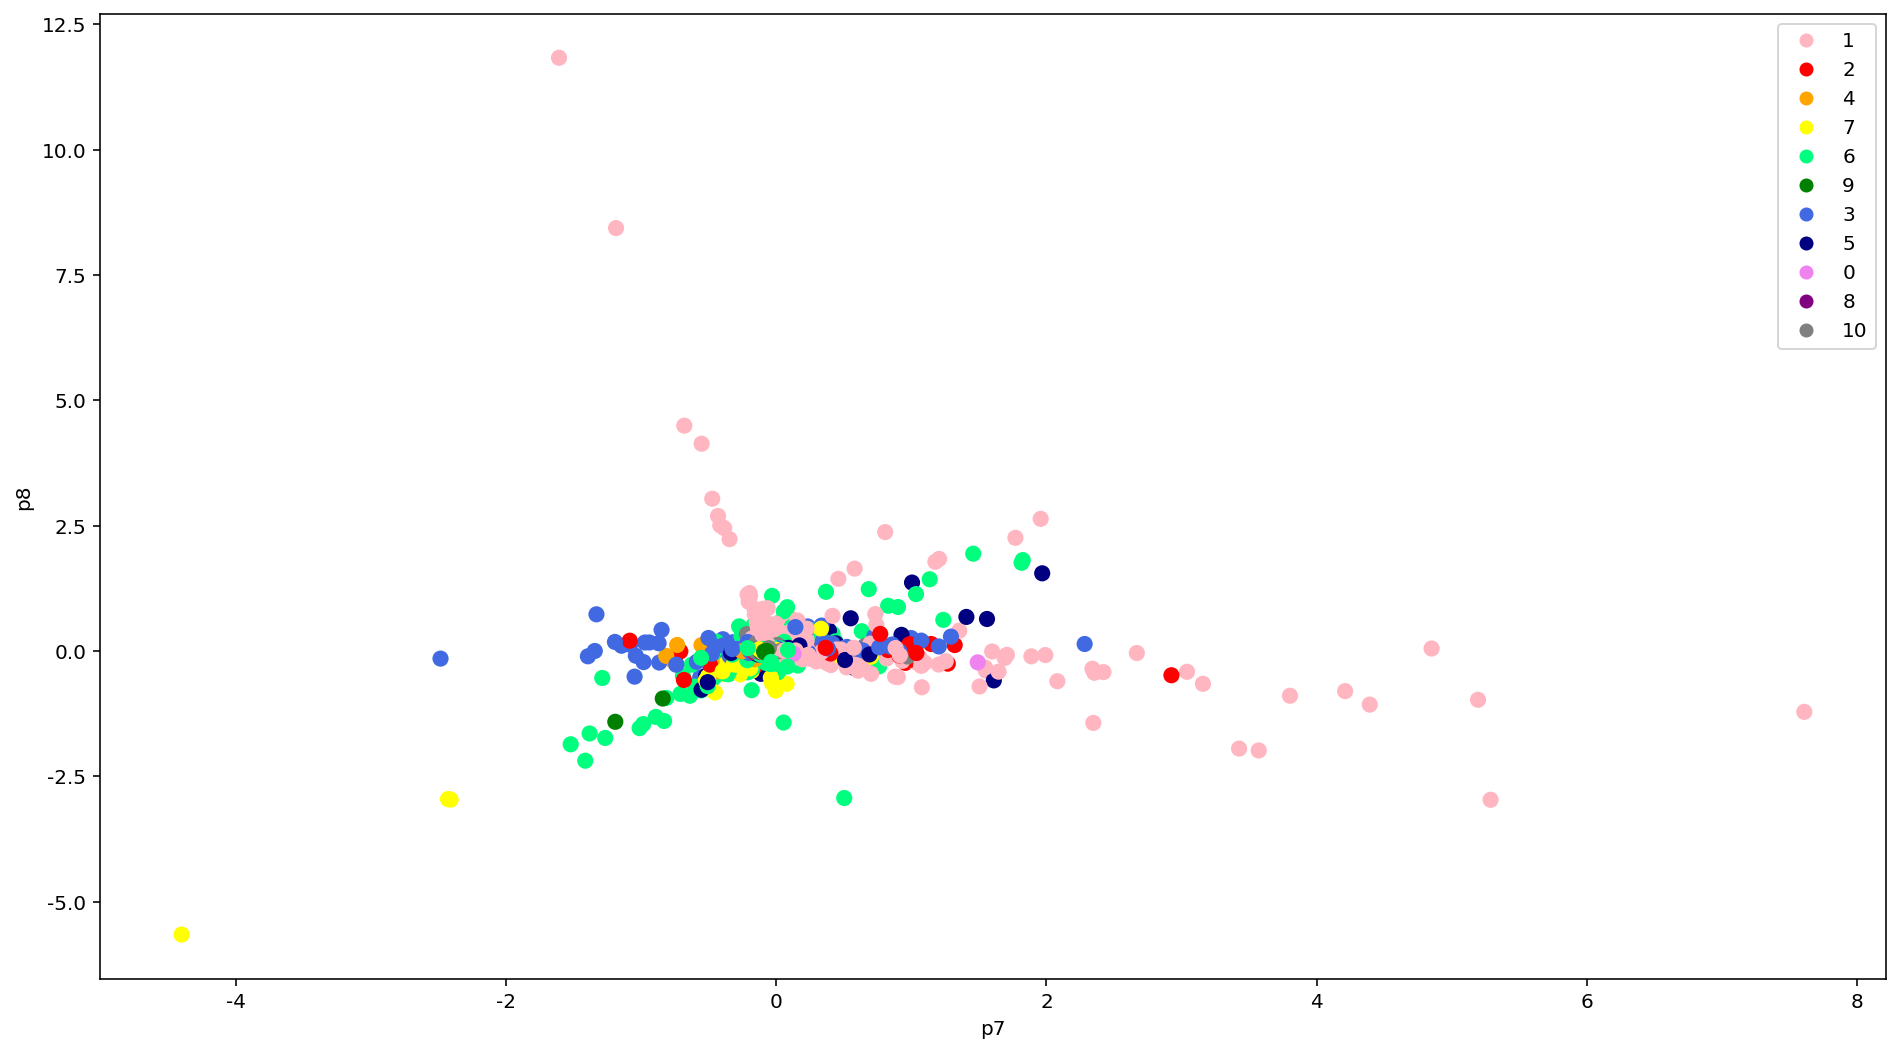

In [343]:
print(" (p7, p8)")
plt.xlabel(f'p{7}')
plt.ylabel(f'p{8}')    
plt.scatter(pc8[:,6], pc8[:,6+1], s=50, c=color_map)
markers = [plt.Line2D([0,0], [0,0], color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.legend(markers, color_dict.keys(), numpoints=1)
plt.show()

由散佈圖大致上可以看出，每個科系類別屬性的科系，比較靠近彼此，走勢較為相似。而且根據選擇不同的components，能看出差異的科系類別也有所不同。

Q2.2 (10%): Visualize academic departments using multiple dimensional scaling. Consider both the metric and non-metric settings. Discuss the result.

### metric

In [272]:
from sklearn.manifold import MDS
features_mds = MDS(n_components=2, metric=True, n_jobs=-1).fit_transform(dep_stu2)


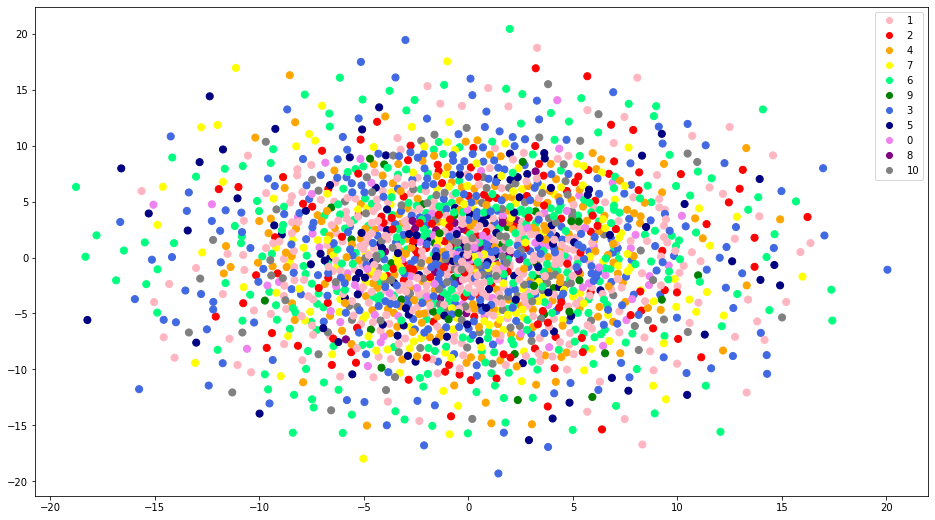

In [273]:
plt.scatter(features_mds[:,0], features_mds[:,1], s=50, c=color_map)
markers = [plt.Line2D([0,0], [0,0], color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.legend(markers, color_dict.keys(), numpoints=1)
plt.show()

### non-metric

In [274]:
features_mds = MDS(n_components=2, metric=False, n_jobs=-1).fit_transform(dep_stu2)

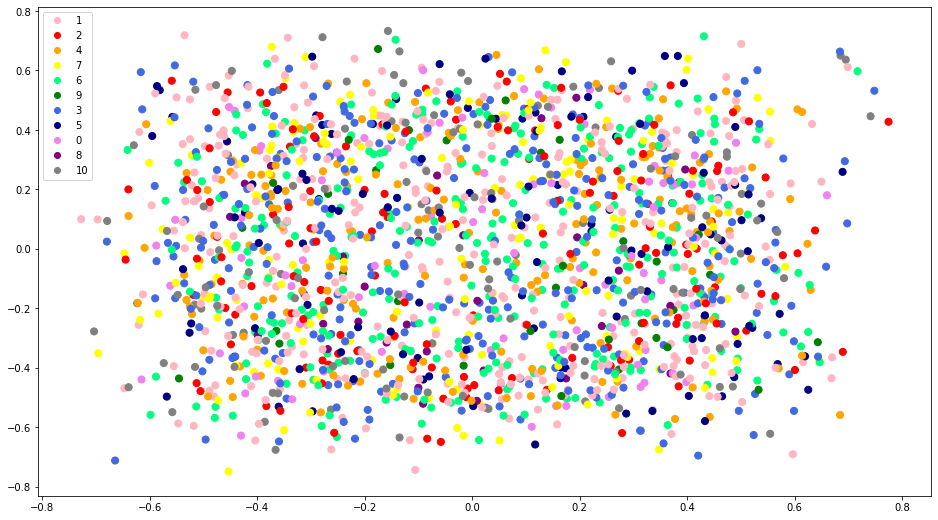

In [275]:
plt.scatter(features_mds[:,0], features_mds[:,1], s=50, c=color_map)
markers = [plt.Line2D([0,0], [0,0], color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.legend(markers, color_dict.keys(), numpoints=1)
plt.show()

兩種mds的資料點都相當散亂，效果不太理想。

Q2.3 (10%): Visualize academic departments using Locally Linear Embedding. Consider three variations: (1) Use 20 neighbors to construct the weight matrix; (2) Use 40 neighbors to construct the weight matrix; (3) Perform PCA transformation first, and use the first 100 principal components as the input to LLE (with 20 neighbors). Discuss the result.

### 20 neighbors

In [285]:
from sklearn.manifold import LocallyLinearEmbedding
features_lle = LocallyLinearEmbedding(n_neighbors=20, n_components=2, n_jobs=-1).fit_transform(dep_stu2)
features_lle.shape

(1917, 2)

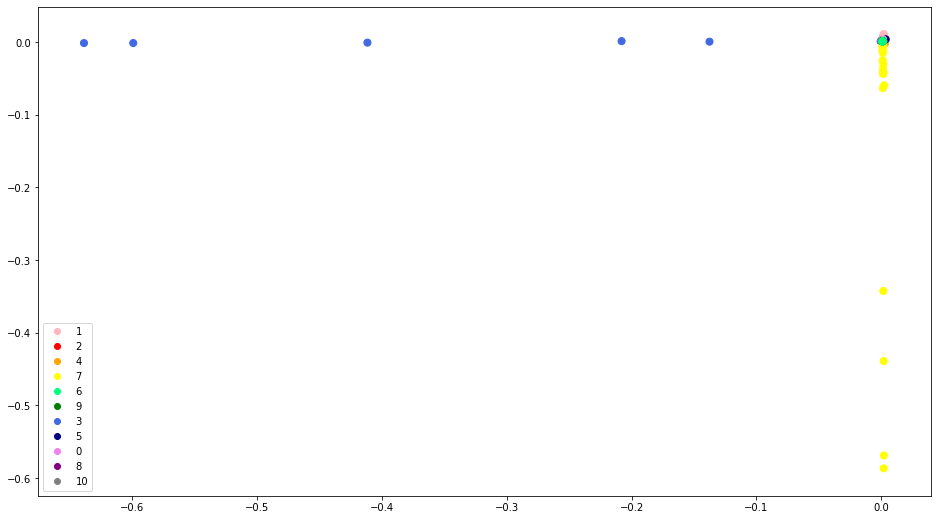

In [286]:
plt.scatter(features_lle[:,0], features_lle[:,1], s=50, c=color_map)
markers = [plt.Line2D([0,0], [0,0], color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.legend(markers, color_dict.keys(), numpoints=1)
plt.show()

只有黃色及淺藍色有明顯的分群，其他的擠在一起，效果不好。

### 40 neighbors

In [291]:
features_lle = LocallyLinearEmbedding(n_neighbors=40, n_components=2, n_jobs=-1).fit_transform(dep_stu2)
features_lle.shape

(1917, 2)

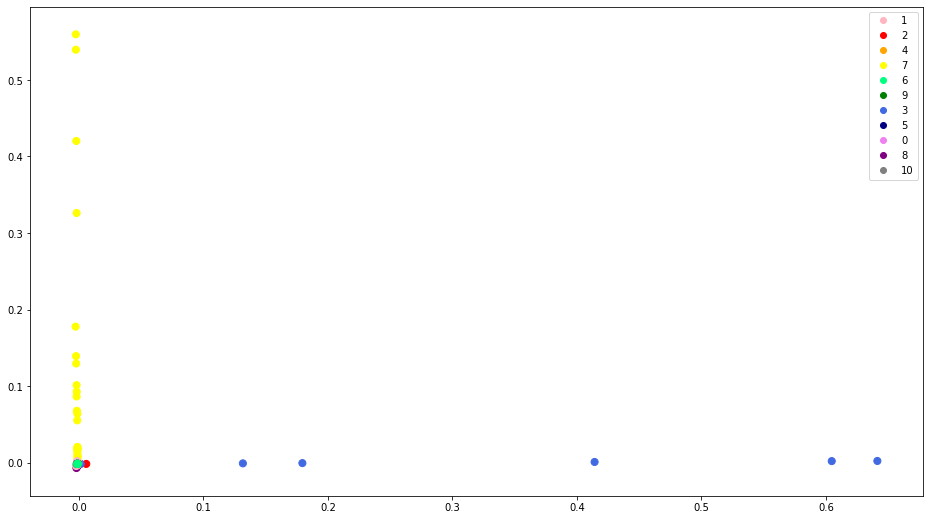

In [292]:
plt.scatter(features_lle[:,0], features_lle[:,1], s=50, c=color_map)
markers = [plt.Line2D([0,0], [0,0], color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.legend(markers, color_dict.keys(), numpoints=1)
plt.show()

只有黃色及淺藍色有明顯的分群，其他的擠在一起，效果不好。

### 20 neighbors + pca

In [287]:
features_pca = PCA(n_components=100).fit_transform(dep_stu2)
features_lle = LocallyLinearEmbedding(n_neighbors=20, n_components=2, n_jobs=-1).fit_transform(features_pca)
features_lle.shape

(1917, 2)

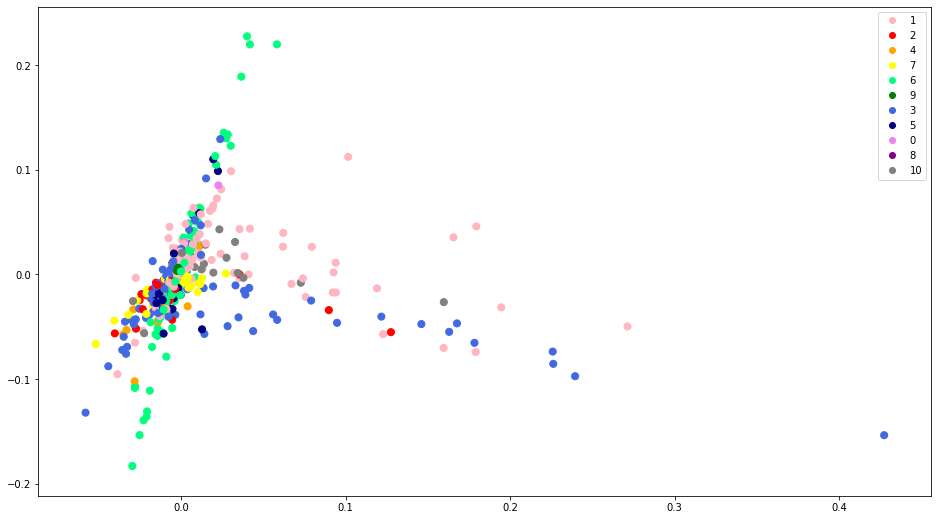

In [288]:
plt.scatter(features_lle[:,0], features_lle[:,1], s=50, c=color_map)
markers = [plt.Line2D([0,0], [0,0], color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.legend(markers, color_dict.keys(), numpoints=1)
plt.show()

先用pca降維，再用lle降維的效果較好，大致可以看出走勢，但像是紫色、橘色等，就混在中間，不是很明顯。

Q2.4 (10%): Visualize academic departments using Kernel PCA. You should at least consider the RBF and Cosine kernel. It is your responsibility to select reasonably good kernel parameters. Discuss the result.

### RBF

In [293]:
from sklearn.decomposition import KernelPCA
features_kpca = KernelPCA(n_components=2, kernel='rbf', n_jobs=-1).fit_transform(dep_stu2)
features_kpca.shape

(1917, 2)

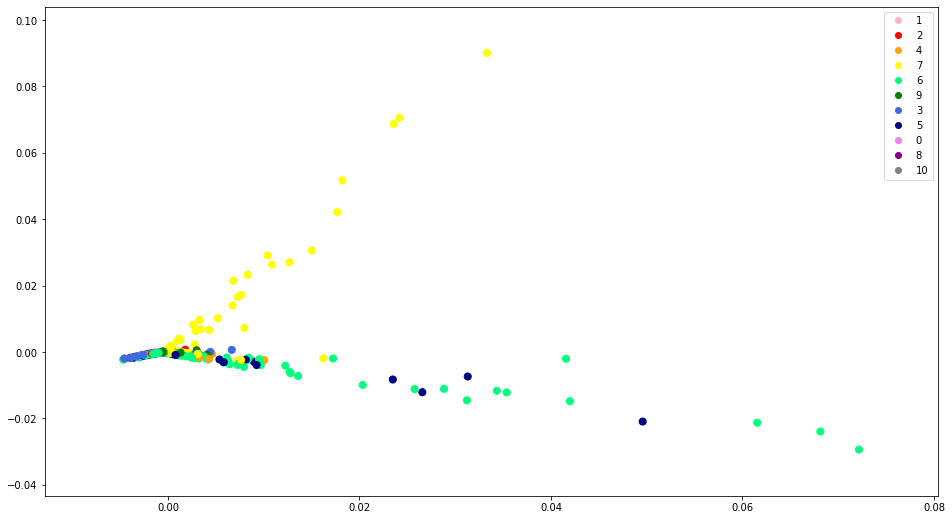

In [294]:
plt.scatter(features_kpca[:,0], features_kpca[:,1], s=50, c=color_map)
markers = [plt.Line2D([0,0], [0,0], color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.legend(markers, color_dict.keys(), numpoints=1)
plt.show()

只有黃色和青綠色較為明顯，其他的擠在一坨，效果不太理想。

### Cosine

In [295]:
features_kpca = KernelPCA(n_components=2, kernel='cosine', n_jobs=-1).fit_transform(dep_stu2)
features_kpca.shape

(1917, 2)

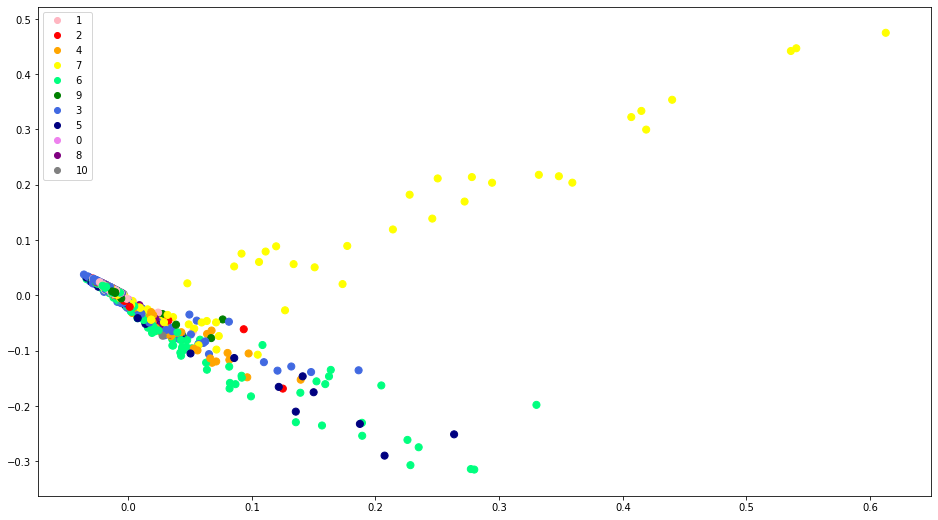

In [296]:
plt.scatter(features_kpca[:,0], features_kpca[:,1], s=50, c=color_map)
markers = [plt.Line2D([0,0], [0,0], color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.legend(markers, color_dict.keys(), numpoints=1)
plt.show()

比rbf略好些，青綠色和淺藍色比較清楚了一點，黃色和青綠色一樣較為明顯，不過整體還是不理想。

Q2.5 (10%): Visualize academic departments using t-SNE. You should consider at least the Euclidian, Cosine, and Jaccard metric. Set numpy random seed so that your results can be repeated. Discuss the result.

### Euclidian

In [297]:
from sklearn.manifold import TSNE
features_tsne = TSNE(n_components=2, metric='euclidean', random_state=999, n_jobs=-1).fit_transform(dep_stu2)
features_tsne.shape

(1917, 2)

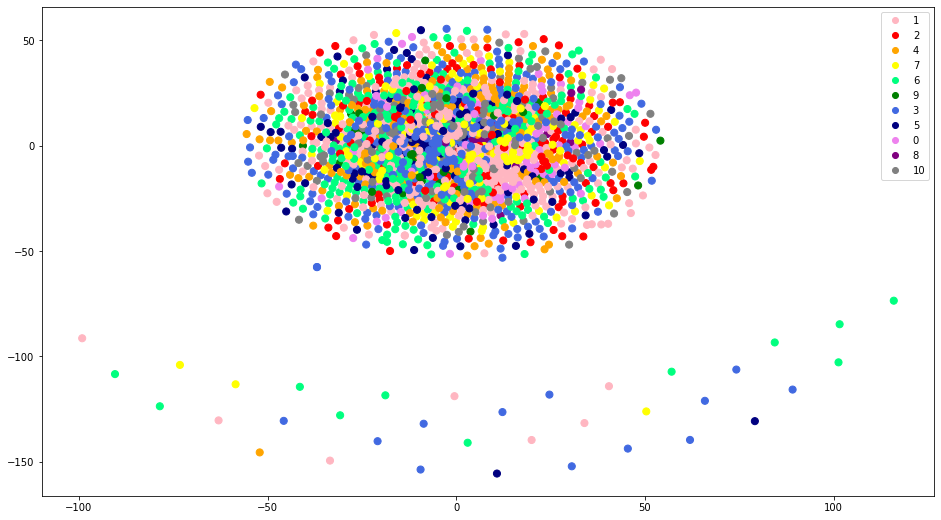

In [298]:
plt.scatter(features_tsne[:,0], features_tsne[:,1], s=50, c=color_map)
markers = [plt.Line2D([0,0], [0,0], color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.legend(markers, color_dict.keys(), numpoints=1)
plt.show()

效果極差，全部擠在上面。

### Cosine

In [299]:
features_tsne = TSNE(n_components=2, metric='cosine', random_state=999, n_jobs=-1).fit_transform(dep_stu2)
features_tsne.shape

(1917, 2)

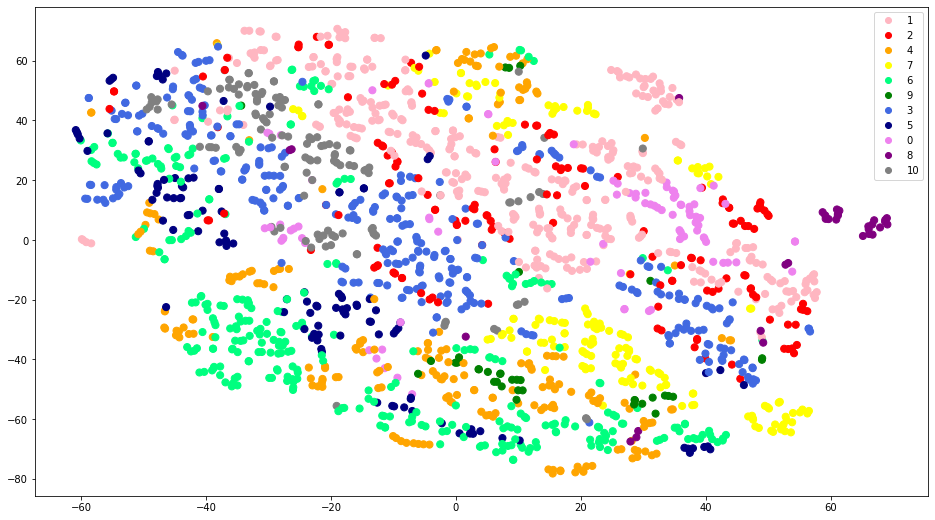

In [300]:
plt.scatter(features_tsne[:,0], features_tsne[:,1], s=50, c=color_map)
markers = [plt.Line2D([0,0], [0,0], color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.legend(markers, color_dict.keys(), numpoints=1)
plt.show()

效果不錯，可以看到各個類別清楚的劃分開來。

Jaccard

In [301]:
features_tsne = TSNE(n_components=2, metric='jaccard', random_state=999, n_jobs=-1).fit_transform(dep_stu2)
features_tsne.shape

(1917, 2)

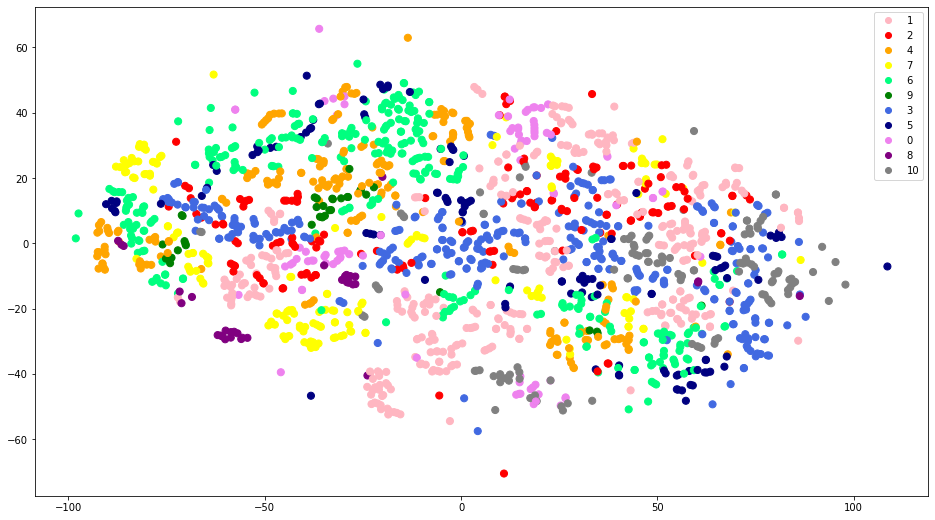

In [302]:
plt.scatter(features_tsne[:,0], features_tsne[:,1], s=50, c=color_map)
markers = [plt.Line2D([0,0], [0,0], color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.legend(markers, color_dict.keys(), numpoints=1)
plt.show()

效果也不錯，各個類別也是清楚的劃分開來。

Q2.6 (10%) Select the most promising visualization method in the previous question and refine the result. You should color points by department category. Label each data point with its name so that we can quickly identify a data point on the picture. Moreover, you should try to reduce the problem caused by overlapping points and labels. Output an image that is large enough so that a user can easily identify a department and its neighbors. Jupyter Lab has limitations on the largest picture size. To overcome this problem, output the picture to a separate file and submit the file for grading. Your score depends on how useful, readable, and visually pleasing of your visualization results.

In [304]:
features_tsne = TSNE(n_components=2, metric='cosine', random_state=999, n_jobs=-1).fit_transform(dep_stu2)
features_tsne.shape

(1917, 2)

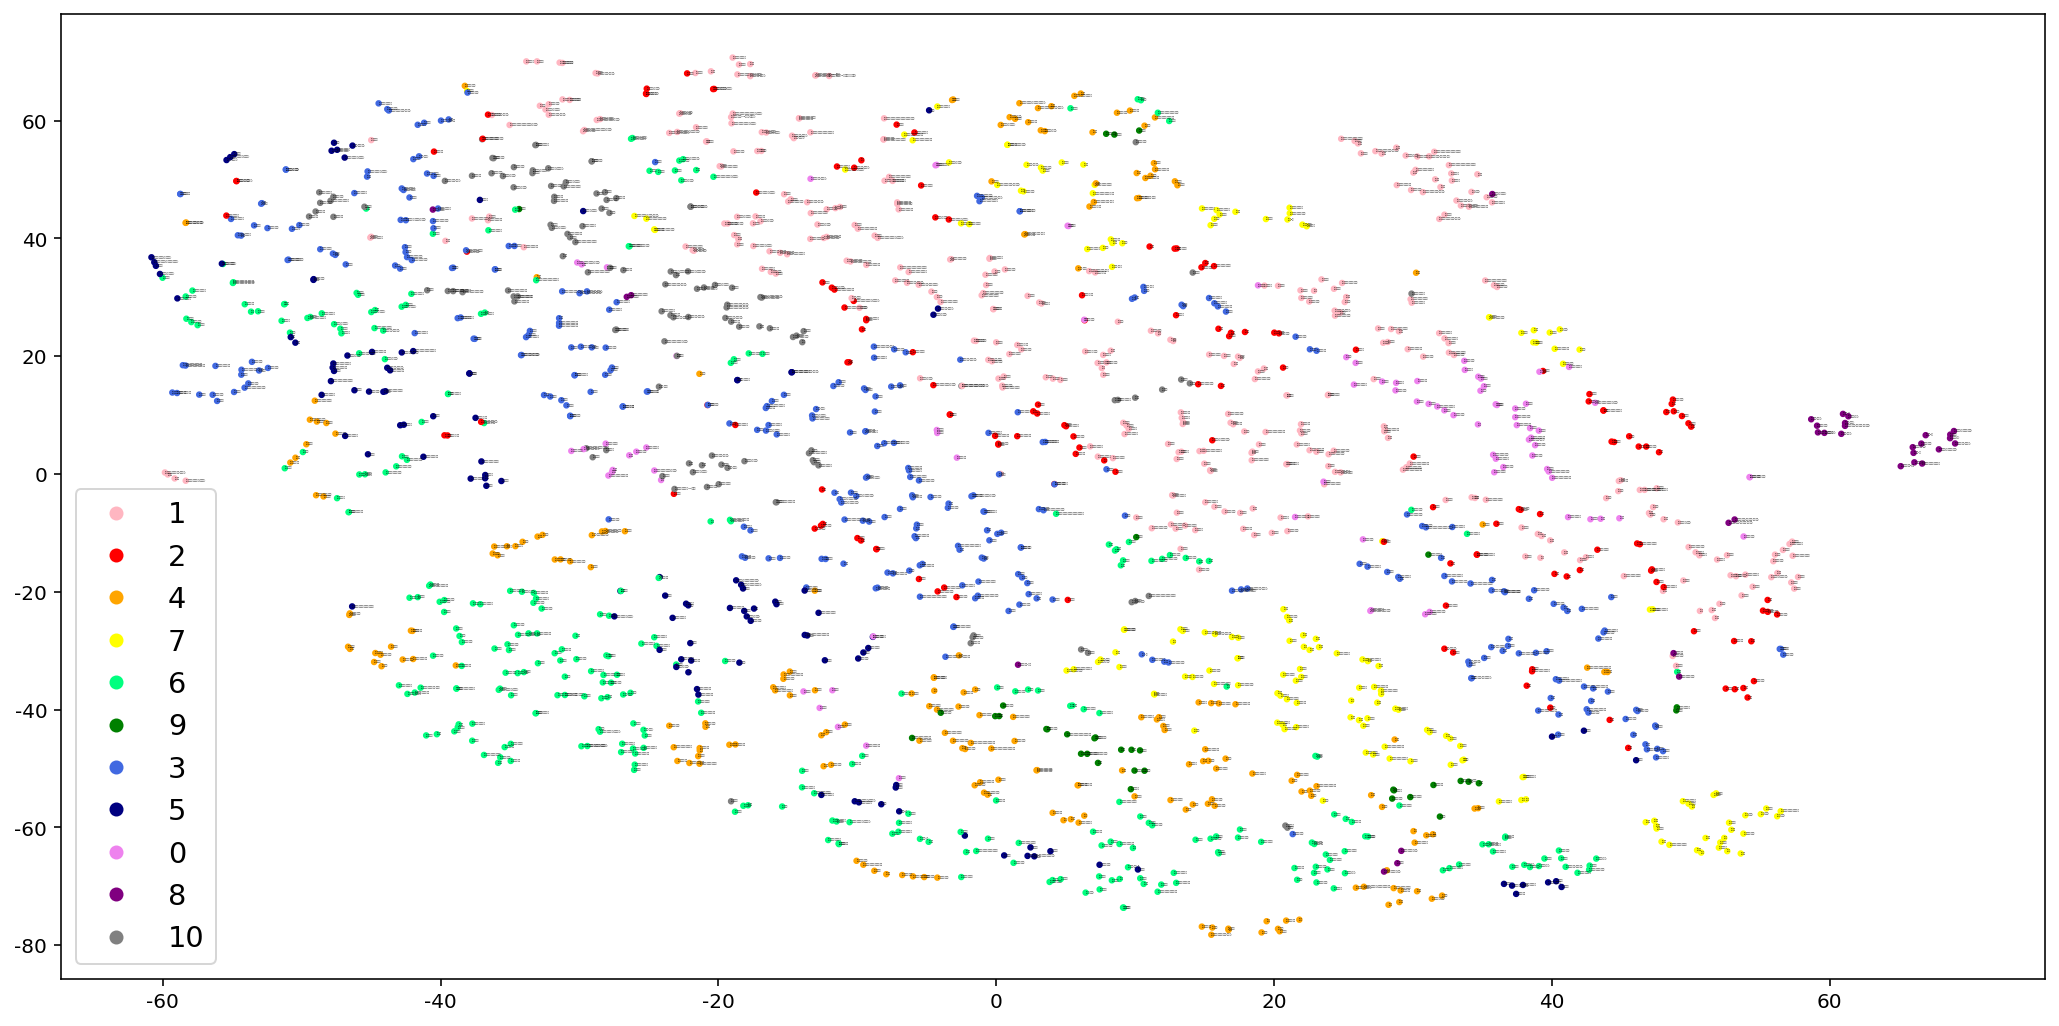

In [349]:
import matplotlib as mpl


mpl.rcParams[u'font.sans-serif'] = ['simhei']
mpl.rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots(figsize=(32,24))

ax.scatter(features_tsne[:,0], features_tsne[:,1], s=5, c=color_map)
markers = [plt.Line2D([0,0], [0,0], color=color, marker='o', linestyle='') for color in color_dict.values()]
ax.legend(markers, color_dict.keys(), numpoints=1, fontsize="x-large")

dname_all = []
for idx in matrix.index.values:
    dname_all.append(uname.loc[uname['department_id'] == idx, 'department_name'].iloc[0])
dname_all = np.array(dname_all)

for i, name in enumerate(dname_all):
    ax.annotate(name, (features_tsne[:,0][i], features_tsne[:,1][i]), fontsize=0.5)

plt.savefig('Q2_6.png', dpi=500)

我認為metric為cosine的tsne效果最好。

---
### Solution
---

Add cells below and answer the questions below.